In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance
%matplotlib inline

In [2]:
def obtainEdges(df):
    edges_list = [];
    for index, info in df.iterrows():
        edges_list.append((info[0], info[1]))
    return edges_list

In [3]:
def obtainAttr(df, target):
    attr_dict = dict()
    for index, info in df.iterrows():
        attr_dict[index] = info[target];
    return attr_dict

In [4]:
def countDegreeProjected(graph, type_):
    
    max_val = max(nx.degree_centrality(graph).values())

    for node, deg in nx.degree_centrality(graph).items():
        if deg == max_val:
            print("Largest degree_centrality: {}".format(max_val), end="")
            print(node)
            if type_ == 'insect':
                print(graph.nodes[node]['insectID'])
            elif type_ == 'plant':
                print(graph.nodes[node]['plant_ge'])

In [5]:
def drawGraph(graph, width, alpha, pos=None):
    fig, ax = plt.subplots(figsize=(20,8))
    ax.set_axis_off()
    nx.draw(graph, pos=pos, width=width, alpha=alpha)

In [6]:
def plotNodesBySize(graph, node_color, alpha):

    size_map = []

    med = np.median(np.array(list(nx.degree_centrality(graph).values())))

    for value in nx.degree_centrality(graph).values():
        if value > med: size_map.append(450)
        else: size_map.append(100)

    fig, ax = plt.subplots(figsize=(20,8))
    pos = nx.spring_layout(graph, iterations=10, scale=3)
    ax.set_axis_off()
    nx.draw_networkx(graph, pos=pos, node_size=size_map, ax=ax, with_labels=True,
           width=0.1, node_color=node_color, alpha=alpha, edgecolors='w', edge_color='k')

In [7]:
def plotNodesByColor(graph, top_nodes, color1, color2, width, alpha):

    color_map = []

    for index, value in graph.nodes(data=True):

        if value['pollinator'] == 1: color_map.append("blue")
        else: color_map.append("green")

    fig, ax = plt.subplots(figsize=(20,10))
    pos = nx.bipartite_layout(graph, top_nodes)
    
    ax.set_axis_off()

    nx.draw_networkx(B, pos = pos,
                     with_labels=False,
                     node_color=color_map,
                     edge_color = "black",
                     width = width,
                     alpha = alpha,
                     node_size = 10,
                     ax = ax)

In [8]:
def create_hierarchical_cluster(G):
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  
    membership = list(hierarchy.fcluster(Z, t=1.15))
    partition = defaultdict(list)
    
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())

In [9]:
def plotBlockModel(graph):

    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    H = graph.subgraph(next(nx.connected_components(graph)))
    H = nx.convert_node_labels_to_integers(H)
    partitions = create_hierarchical_cluster(H)
    block_model = nx.quotient_graph(H, partitions, relabel=True)

    pos = nx.spring_layout(H, iterations=100)
    nx.draw(H, pos, with_labels=True, node_size=10, ax=axs[0])

    node_size = [block_model.nodes[x]["nnodes"] * 10 for x in block_model.nodes()]

    pos_block_model = {}
    for n in block_model:
        xy = np.array([pos[u] for u in block_model.nodes[n]["graph"]])
        pos_block_model[n] = xy.mean(axis=0)
    nx.draw(block_model, pos_block_model, node_size=node_size,
            with_labels=False, ax=axs[1])

In [10]:
def findCompetitors(source, graph):
    insects_id = sorted(source["# index"].unique())

    pairs = dict()

    for u in range(len(insects_id)):
        for v in range(len(insects_id)):
            if v > u:
                competitor1 = insects_id[u]
                competitor2 = insects_id[v]

                pair = tuple([competitor1, competitor2])
                compete = len(list(nx.common_neighbors(graph, competitor1, competitor2)))

                pairs[pair] = compete
    
    max_val = max(pairs.values())
    
    count = 1
    
    for i, j in pairs.items():
        if j == max_val:
            print(f'pair {count}')
            print(f'competitorA: Index: {i[0]} name: {graph.nodes[i[0]]["insectID"]}')
            print(f'competitorB: Index: {i[1]} name: {graph.nodes[i[1]]["insectID"]}')
            print(f'number of same plants: {max_val}')
            print("\n\n")
            
            count += 1

In [11]:
def countNode(nodes):
    
    insects, plants = 0, 0;
    
    for node, attr in nodes:
        if attr['pollinator'] == 0: insects += 1
        else: plants += 1
    
    return (insects, plants)

In [12]:
def countDegree(graph, type_):
    
    degrees = {}
    nodes = {}
    
    if type_ == 'insect':
        for node, attr in graph.nodes(data=True):
            if attr["pollinator"] == 1:
                degrees['#Index: {} name: {}'.format(node,
                                                     attr['insectID'])] = graph.degree(node)
                
        target = max(degrees.values())

        for node, degree in degrees.items():
            if degree == target:
                nodes[node] = degree;
                        
        return nodes
                    
                
    elif type_ == 'plant':
        for node, attr in graph.nodes(data=True):
            if attr["pollinator"] == 0:
                degrees['#Index: {} name: {}'.format(node,
                                                     attr['plant_ge'])] = graph.degree(node)
                
        target = max(degrees.values())

        for node, degree in degrees.items():
            if degree == target:
                nodes[node] = degree;
                        
        return nodes
                
    else: return "Error"
                    

In [13]:
nodes = pd.read_csv('nodes_l6.csv')

In [14]:
edges = pd.read_csv('edges_L6.csv')

In [15]:
edges.head()

,# source,target,count
0,0,40,1
1,94,34,1
2,95,12,1
3,95,39,1
4,96,55,1


In [16]:
nodes.head()

,# index,idx,pollinator,pol_ge_sp,plant_ge,plant_sp,_pos
0,0,53,1,ACHILIDAE1 (Ach. : Hem. ),NaN,NaN,"array([-0.56541095, -2.76309565])"
1,1,1,0,NaN,Acer,rufinerve,"array([-0.1164353 , -2.07462624])"
2,2,2,0,NaN,Adenocaulon,himalaicum,"array([-0.12344886, -2.43315122])"
3,3,3,0,NaN,Aesculus,turbinata,"array([-0.14942567, -2.65879824])"
4,4,4,0,NaN,Agrimonia,pilosa,"array([-0.1462946 , -2.48239974])"


### Question1

In [17]:
# { if 1 => insects,  else 0 => plants
insects = nodes[nodes["pollinator"] == 1]
plants =  nodes[nodes["pollinator"] == 0]

In [18]:
B = nx.Graph()

In [19]:
B = nx.from_pandas_edgelist(edges, '# source', 'target', edge_attr = 'count')

In [20]:
# set node attributes
nx.set_node_attributes(B, obtainAttr(nodes, 'pollinator'), 'pollinator')
nx.set_node_attributes(B, obtainAttr(nodes, 'pol_ge_sp'), 'insectID')
nx.set_node_attributes(B, obtainAttr(nodes, 'plant_ge'), 'plant_ge')
nx.set_node_attributes(B, obtainAttr(nodes, 'plant_sp'), 'plant_sp')
nx.set_node_attributes(B, obtainAttr(nodes, ' _pos'), '_pos')

In [21]:
# check whether B is connected.
if nx.is_connected(B):
    bottom_nodes, top_nodes = bipartite.sets(B)
    
else:
    top_nodes = {n for n, d in B.nodes(data=True) if d["pollinator"] == 1}
    bottom_nodes = set(B) - top_nodes

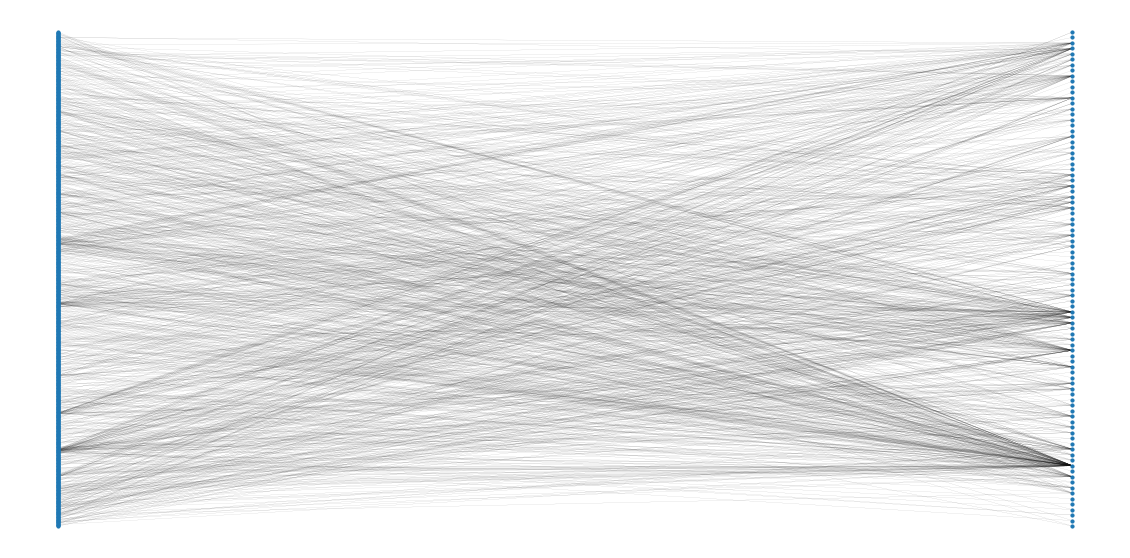

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
pos = nx.bipartite_layout(B, top_nodes)

ax.set_axis_off()

nx.draw_networkx(B, pos = pos,
                 with_labels=False,
                 edge_color = "black",
                 width = 0.05,
                 node_size = 10,
                 ax = ax)

> Question1a: Number of nodes in each node set

In [23]:
# For the number of node set of insects and plants:
countNode(B.nodes(data=True))

(91, 679)

The number of nodes for insect node set is 679, meaning 679 insects in the data.
And, the number of nodes for plants node set is. 93, meaning plants insects in the data

> Question1b: Number of edges in the bipartite network

In [24]:
# For the number of node set of edges:
nx.info(B).split('\n')[3]

'Number of edges: 1206'

As shown in the output, the number of edges in the bipartite network is 1206

### Question2

In [25]:
list(countDegree(B, 'plant').keys())

['#Index: 12 name: Anthriscus']

In [26]:
list(countDegree(B, 'plant').values())

[189]

As shown in the output, the plant pollinated by most insects is Anthriscus (with an index of 12). The number of insects pollinated to this plant is 189.

In [27]:
list(countDegree(B, 'insect').keys())

['#Index: 196 name: Bombus (Diversobombus) diversus diversus (Api. : Hym. )',
 '#Index: 198 name: Bombus (Thoracobombus) honshuensis (Api. : Hym. )']

In [28]:
list(countDegree(B, 'insect').values())

[25, 25]

As shown in the output, the insect pollinating most plants are "Bombus (Diversobombus) diversus diversus (Api. : Hym. )" and "Bombus (Thoracobombus) honshuensis (Api. : Hym. )". The number of plants they pollinate to is 25.

### Question3

In [29]:
findCompetitors(insects, B)

pair 1
competitorA: Index: 196 name: Bombus (Diversobombus) diversus diversus (Api. : Hym. )
competitorB: Index: 198 name: Bombus (Thoracobombus) honshuensis (Api. : Hym. )
number of same plants: 10



pair 2
competitorA: Index: 398 name: Eristalis cerealis (Syr. : Dip. )
competitorB: Index: 481 name: Lasioglossum (Et.) apristum (Hal. : Hym. )
number of same plants: 10





As shown in the output, there are 2 pairs which are the strongest competitors to each pair defined by *pollinating the largest numbers of same plants*.

Both pairs compete over 10 plants. For pair 1, the competitors are "Bombus (Diversobombus) diversus diversus (Api. : Hym. )" and "Bombus (Thoracobombus) honshuensis (Api. : Hym. )". For pair 2, the competitors are "Eristalis cerealis (Syr. : Dip. )" and "Lasioglossum (Et.) apristum (Hal. : Hym. )".

### Question4

In [30]:
G_1 = bipartite.weighted_projected_graph(B, top_nodes)
G_2 = bipartite.weighted_projected_graph(B, bottom_nodes)

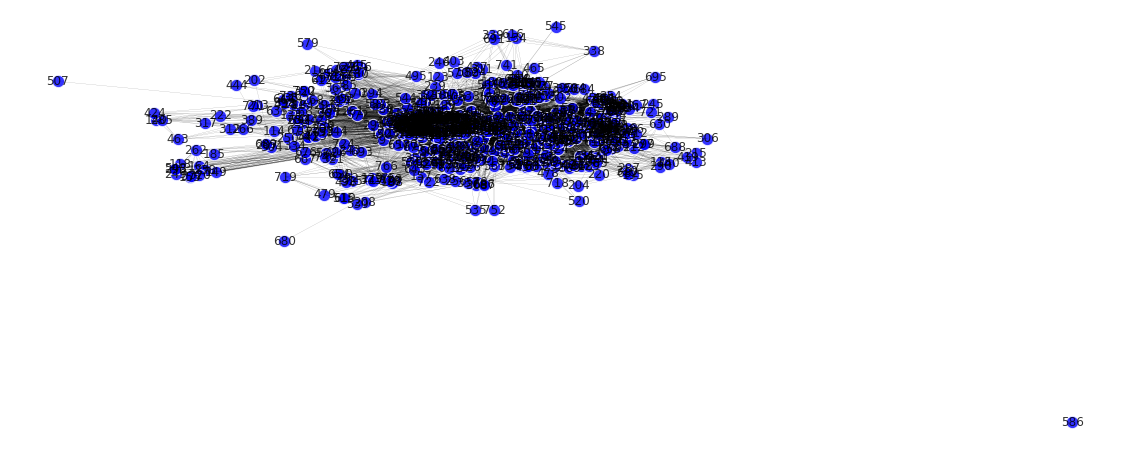

In [31]:
# Projected Insect Network
fig, ax = plt.subplots(figsize=(20,8))
pos = nx.spring_layout(G_1, iterations=10, scale=3)
ax.set_axis_off()
nx.draw_networkx(G_1, pos=pos, node_size=150, ax=ax, with_labels=True,
       width=0.1, node_color="blue", alpha=0.8, edgecolors='w', edge_color='k')

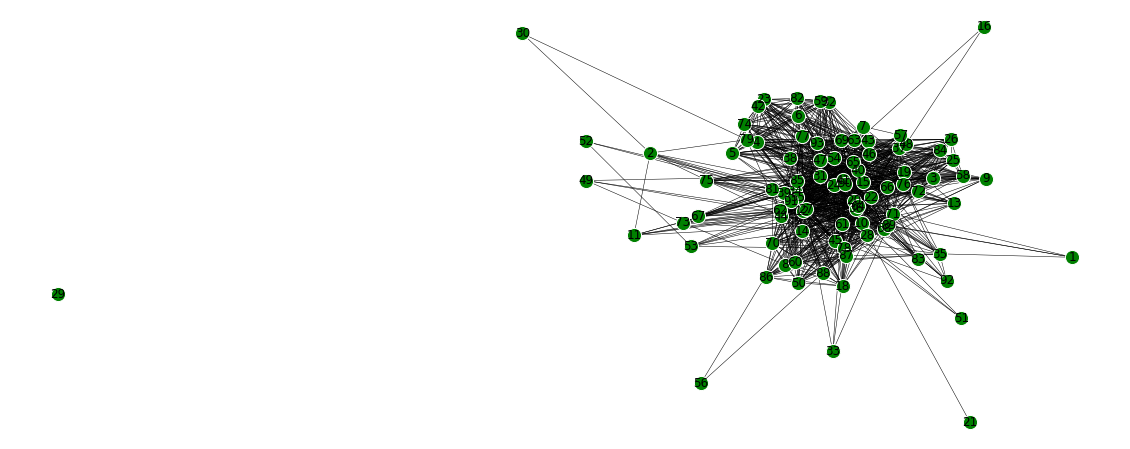

In [32]:
# Projected Insect Network
fig, ax = plt.subplots(figsize=(20,8))
pos = nx.spring_layout(G_2, iterations=10)
ax.set_axis_off()
nx.draw_networkx(G_2, pos=pos, node_size=200, ax=ax, with_labels=True, edgecolors='w',
       width=0.5, node_color="green")

> Question 4a: Projected Insect Network (G_1)

For the projected insect network, each of the edges connecting any generic node v and node u in the network mean that node v and node u (generic insects v and u) have pollinated at least 1 plant together.

> Question 4a: Projected Plant Network (G_2)

For the projected plant network, each of the edges connecting any generic node v and node u in the network mean that node v and node u (generic plants v and u) have been pollinated by at least 1 same insect.

> Question 4b: Summary information for G_1

In [33]:
for i in nx.info(G_1).split("\n"): print(i) 

Name: 
Type: Graph
Number of nodes: 679
Number of edges: 31443
Average degree:  92.6156


As shown in the results, in the projected insect network, there are 679 nodes representing 679 insects.<br />  Also, there are 31443 edges in G_1, each *generic edge* connecting any *node v and node u* represents that these node v and node u pollinate 1 same plant (is a neighbor to each other in at least 1 plant). <br /> For the average degree of 92.6156, it represents the average number of edges per node in the graph. In this context, this average degree means that for each insect, in average, each has 92.6156 neighbors of insects (insects pollinating the same plant) across one or more plants.

> Question 4b: Summary information for G_2

In [34]:
for i in nx.info(G_2).split("\n"): print(i) 

Name: 
Type: Graph
Number of nodes: 91
Number of edges: 1345
Average degree:  29.5604


As shown in the results, in the projected plant network, there are 93 nodes representing 93 plants. <br />
Also, there are 1345 edges in G_2, each generic edge connecting any node v and node u represents that node v and node u are pollinated by 1 same insect (is a neighbor to each other where both plants are pollinated by 1 particular insect). <br />
For the average degree of 28.9247, it represents the average number of edges per node in the graph. In this context, the average degree means that for each plan, in average, each has 28.9247 neighbors of plants (plants pollinated by same insects) pollinated by one or more insects.

### Question5

In [35]:
countDegreeProjected(G_1, 'insect')

Largest degree_centrality: 0.7168141592920354398
Eristalis cerealis (Syr. : Dip. )


In [36]:
countDegreeProjected(G_2, 'plant')

Largest degree_centrality: 0.890
Weigela


> Question 5a: Degree centrality interpretations

For the projected insect network, the meaning of degree centrality of 0.7168 is that the node "*Eristalis cerealis (Syr. : Dip. )*" has the strongest connections to other nodes in the network. Under this context, across all the plants that the node  "*Eristalis cerealis (Syr. : Dip. )*" pollinated to, the node can find 71.68% of other nodes (insects) in the network,  which is the largest amount in the network.


For the projected plant network, the meaning of degree centrality of 0.7826 is that the node "*Weigela*" has the strongest connections to other other nodes in the network. Under this context, across all insect pollinated to the plant "*Weigela*", the plant can find 78.26% of other plants in the network, which is the largest amount in the network. 

> Question 5b: Compared the results to question 2

They are different graphs with different meanings. The graphs in Question 5 are projected graphs for a set of nodes in the bipartite graph in Question 2. Therefore, the meanings of degree of centrality in such 2 cases are different too. <br />

For the degree centrality in Question 2, it measures the connectness between plants and insects, which is between-group comparison.
<br />
For the degree centrality in Question 5, it's an in-group comparison, which measures the connectness between all the plants or the connectness between all the insects.

###  Question 6

In [37]:
list(nx.isolates(G_1))

[586]

In [38]:
list(nx.isolates(G_2))

[29]

The meaning of isolated node (insect index @ 586) in the projected insect network (G_1) means that the node cannot find other nodes through the plant that it pollinated to

> **Explanation**

In [39]:
edges[edges["# source"] == 586]

,# source,target,count
948,586,29,1


In [40]:
edges[edges["target"] == 29]

,# source,target,count
948,586,29,1


The above output showed that the plant index @ 29 has only 1 pollinator which is exactly the isolate node. Whilst, the node only pollinated to the plant index @ 29. Hence, the node is isolated because it could not find any other nodes through it's only pollinated plant index @ 29

The meaning of isolated nodes (plant index @ 17, 29, 80) in the projected plant network (G_2) means that the nodes cannot find other nodes through the insects. The possible reason is pretty sad, which is they are not being pollinated at all.

> **Explanation**

In [41]:
edges[edges["target"] == 17], edges[edges["target"] == 80]

(Empty DataFrame
 Columns: [# source, target, count]
 Index: [],
 Empty DataFrame
 Columns: [# source, target, count]
 Index: [])

As we can see from the output, they are isolated simply because no insect pollinated to them.

In [42]:
edges[edges["target"] == 29]

,# source,target,count
948,586,29,1


Similar the result for explanation of the isolated nodes in projected insect network, the insect pollinated to the plant index @ 29 only pollinated to 1 plant and that's it. Therefore, the plant index @ 29 cannot find other plants in the network because or short-sighted insect index @ 586.

### Question 7

> **Block Modeling**

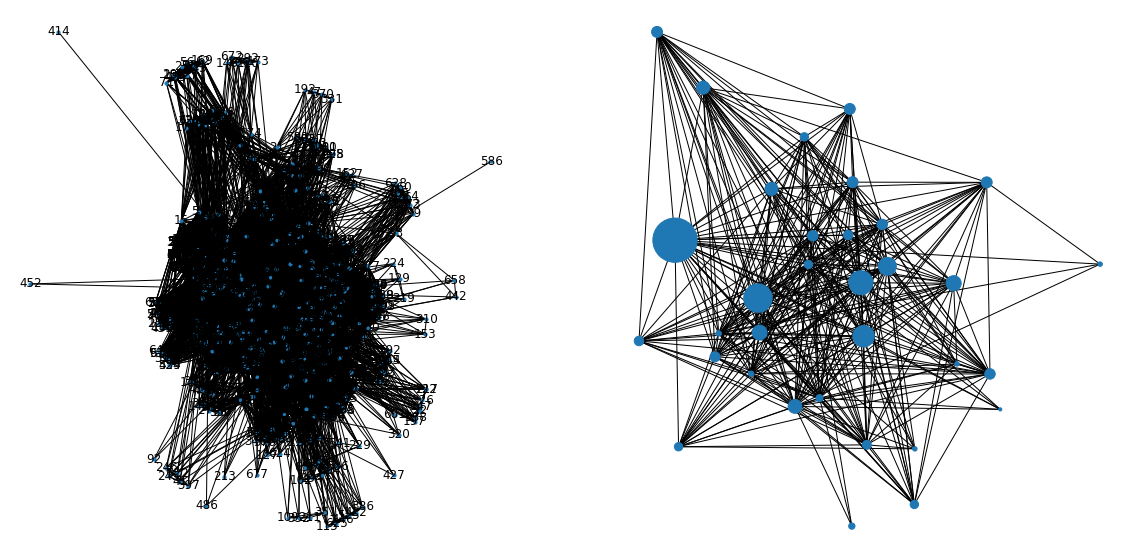

In [43]:
plotBlockModel(G_1)

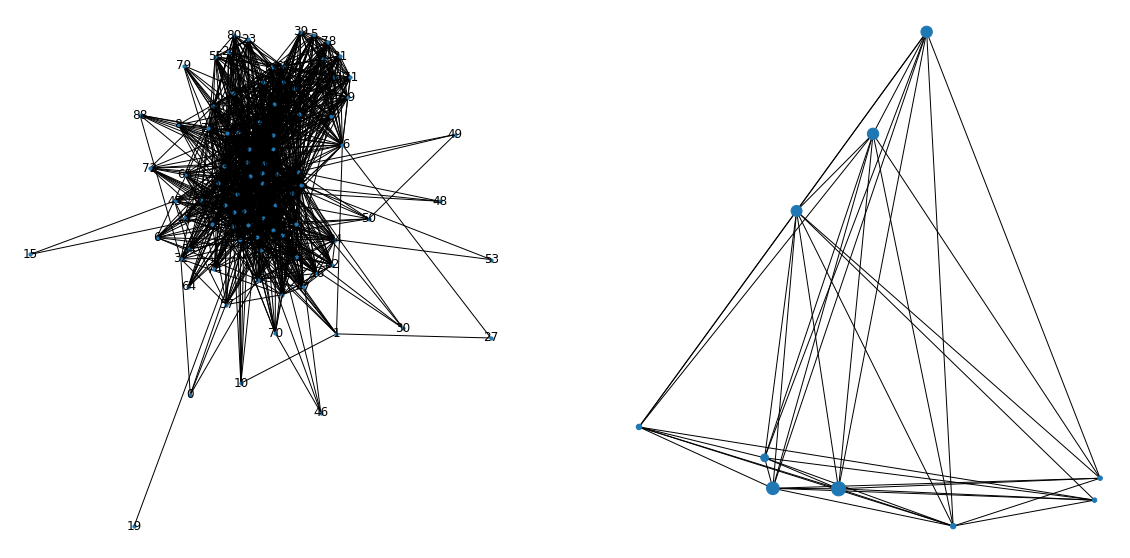

In [44]:
plotBlockModel(G_2)

Blockmodel, my favourite graph in this assignment, because it's like the purpose of CNN (convolutional neural network), capturing some features over some images. haha... 
<br/>
Back to the topic, for the above graphs, the left hand side is the original graph of proejcted insect/ plant network with isolated nodes removed and the right hand side are the block models with weighted edges.
<br/>
As observed in those models, the structures are similar with the original graphs while many edges and nodes are removed, and 
1. Each nodes in the model represents a cluster in the network. 
2. The sizes of nodes represent how big the clusters are.
3. The edges of nodes represent the connections between clusters.

<br/>
Under the context, for the projected insect network, <br />
1. The nodes represent the clusters for insects, meaning that some groups of insects pollinated correspondingly to some particular alike plants. <br/>
2. The biggest node (Largest number of insects in a single cluster) there indicates the biggest cluster in the network, which indicates that the largest number  of insect neighbours could be found in this cluster. <br />
3. Also, edges between nodes indicate the connections between the clusters, which is meant that insects in two clusters pollinate to same plant(s) for each edge.<br />

<br/>
For the projected plant network, <br />
1. The nodes represent the clusters for plants, meaning that some groups of plants are being pollinated correspondingly by some p insects. <br/>
2. The biggest node (Largest number of plants in a single cluster) there indicates the biggest cluster in the network, which indicates that the largest number of plant  neighbours could be found in this cluste. <br /> 
3. And, edges between nodes indicate the connections between the clusters, which is meant that each clusters being pollinated by same insect(s) for each edge.

### Question 8

In [45]:
nx.degree_assortativity_coefficient(G_1)

0.14973550731876661

In [46]:
nx.degree_assortativity_coefficient(G_2)

-0.15103115294930652

The assortativity is ranged from -1 to 1 (like correlation coefficient r). While the positive assortativity values indicating tendancy for nodes or similar degrees to connect to each others, the negative values imply that the large-degree nodes tend to attach to low-degree nodes. For the above input, the strength of assortativity is quite weak (the patterns are not obvious) which are just around positive or negative .15.
<br /><br />
For the projected insect network(G_1), the assortativity values is around 0.15, which indicates that the nodes slightly/ weakly tend to attach to nodes with similar degrees. Under this context, it means that insects with similar number of insect neighbors across the plants may (again, the assortaivity is weak to tell) tend to be able to find each other in the network, although the indication is not convincing at all.
<br /><br />
For the projected plant network(G_2),  the assoratativity values is around -0.15, which indicates that the large-degree nodes slightly/ weakly tend to attach low degree nodes. Under this context, it means that plants with large number of neighbors over pollinated plants may tend to find other plans with small number of neighbors (the assortativity is weak to tell, again) in the network, although the indication is not convincing at all.

### Quesiton 9

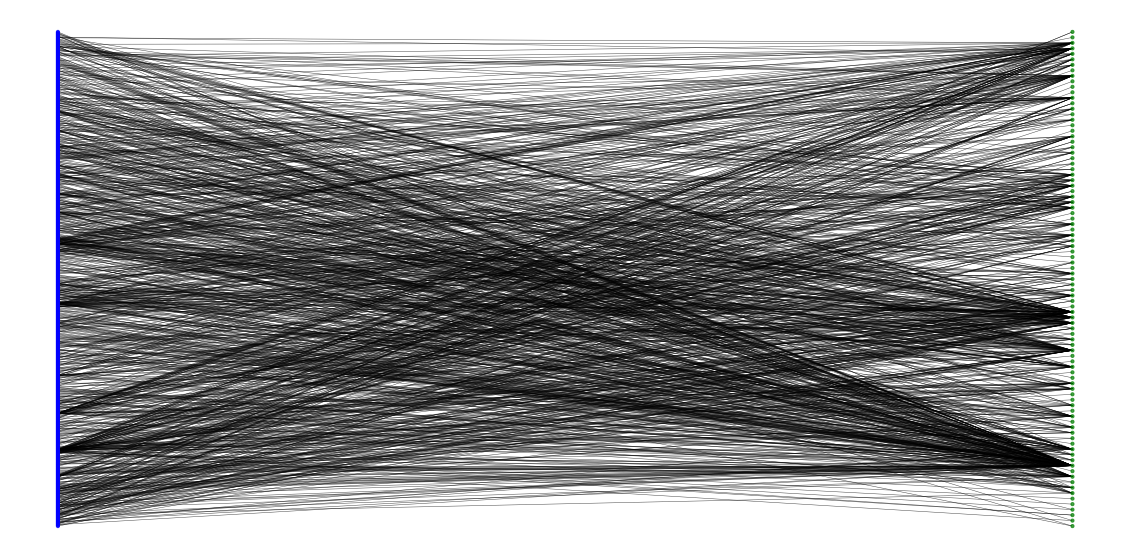

In [47]:
plotNodesByColor(B, top_nodes, "blue", "green", 0.5, 0.7)

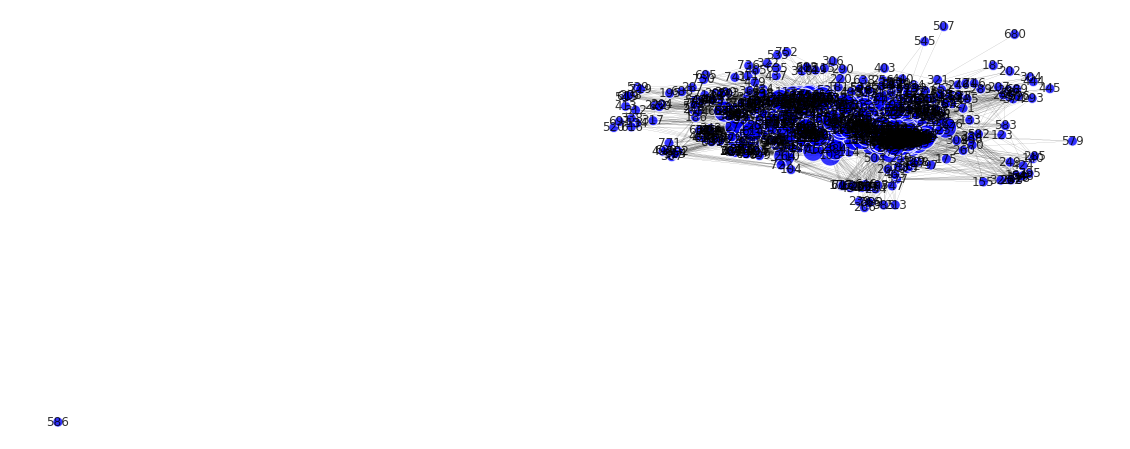

In [48]:
plotNodesBySize(G_1, 'blue', 0.8)

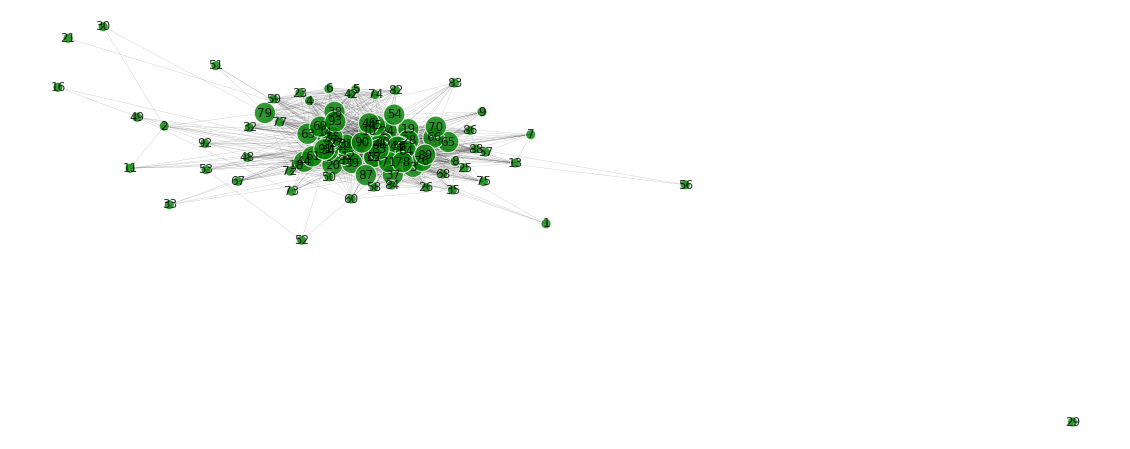

In [49]:
plotNodesBySize(G_2, 'green', 0.8)